In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.linear_model import LogisticRegression
import sklearn.metrics

from collections import Counter
import csv
import datetime
from glob import glob
import io
import json
import pickle
import operator

from pathlib import Path

import matplotlib.pyplot as plt

In [2]:
from pyspark import SparkContext, SparkConf, SQLContext

In [3]:
import gensim.utils
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups

nlp = spacy.load('en')
lookups = Lookups()
for table in nlp.vocab.lookups.tables:
    lookups.add_table(table, nlp.vocab.lookups.get_table(table))
lemmatizer = Lemmatizer(lookups)

stop_words = stopwords.words('english')

def process(t):
    t = gensim.utils.simple_preprocess(t)
    t = [lemmatizer.lookup(w) for w in t if w not in stop_words]
    return t

vectorizer = TfidfVectorizer(min_df=4,
                             tokenizer=lambda x: x, 
                             preprocessor=lambda x: x,
                            ngram_range=(1, 3),
                            max_features=10000,
                            max_df=0.75,
                            )

with open('../data/vocabulary-classifier.pickle', 'rb') as f:
    vectorizer.vocabulary_, vectorizer.idf_, clf = pickle.load(f)


/Users/corrado/.conda/envs/10-dim-of-op-change/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/Users/corrado/.conda/envs/10-dim-of-op-change/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.22.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [4]:
def classify_proba(txt):
    tfidf = vectorizer.transform([process(txt)])
    return clf.predict_proba(tfidf)[0, 1]

def classify(txt):
    tfidf = vectorizer.transform([process(txt)])
    return clf.predict(tfidf)[0] > 0

In [5]:
classify_proba("hello i am interested in bernie, what is democratic socialism")

0.9999999685187481

In [6]:
classify_proba("hello i am a fan of videogames, did Tony Hawk make a videogame?")

0.07689345040629107

In [7]:

sc = SparkContext()

In [8]:
def resilient_json(s):
    try:
        return json.loads(s)
    except: # pylint: disable=W0702
        return {}

In [10]:
post2label_rdd = (
    sc.textFile("/data/big/reddit/submissions/*/*.bz2")
    .map(resilient_json)
    .filter(lambda p: p.get('subreddit', '').lower() == 'changemyview')
    .filter(lambda p: len(p.get('selftext', '').strip()) > 10) # [removed] and [deleted] are 9 characters
    .map(lambda p: (p, classify(p.get('selftext'))))
)
post2label_rdd.persist()

(post2label_rdd
     .filter(operator.itemgetter(1))
     .map(operator.itemgetter(0))
     .map(json.dumps)
     .saveAsTextFile('../data/changemyview-sociopol',
                    compressionCodecClass="org.apache.hadoop.io.compress.GzipCodec")
)

In [12]:
! zcat ../data/changemyview-sociopol/part-*.gz | \
    gzip --stdout > ../data/changemyview-sociopol.gz

In [13]:
! rm -rf ../data/changemyview-sociopol

In [14]:
def to_yearmonth(x):
    ts = int(x[0].get('created_utc', 0))
    dt = datetime.datetime.fromtimestamp(ts)
    return ((dt.year, dt.month, "pos" if x[1] else "neg"), 1)

In [15]:
timepos2count = (
    post2label_rdd
    .map(to_yearmonth)
    .reduceByKey(lambda a, b: a + b)
    .collect()
)

In [16]:
timepos2count = dict(timepos2count)

In [17]:
t2pos, t2neg = (np.array([timepos2count.get((y, m, label), 0) 
 for y in range(2011, 2020) for m in range(1, 13)]) for label in ('pos', 'neg'))

In [18]:
print(np.sum(t2pos), "total sociopolitical posts on r/ChangeMyView")

46043 total sociopolitical posts on r/ChangeMyView


In [19]:
print(np.sum(t2neg), "total NON-sociopolitical posts on r/ChangeMyView")

19684 total NON-sociopolitical posts on r/ChangeMyView


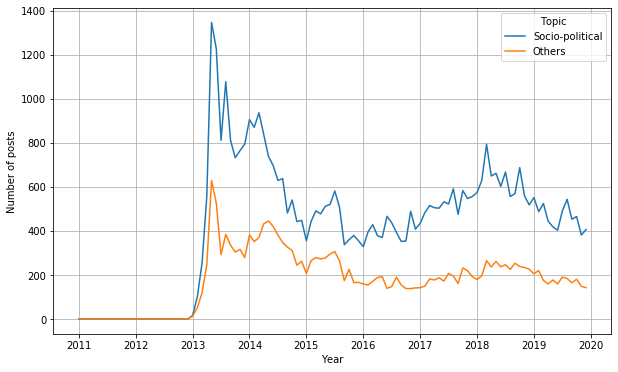

In [22]:
plt.rcParams.update({'font.size': 10, 
                     'axes.labelcolor': 'k',
                     'xtick.color': 'k',
                     'ytick.color': 'k'
                    })
plt.figure(figsize=(10, 6))
plt.plot(t2pos, label="Socio-political")
plt.plot(t2neg, label="Others")
plt.grid()
plt.xticks(np.arange(0, len(t2pos) + 1, 12), 
           [f"{y}" for y in range(2011, 2021)])
plt.ylabel("Number of posts")
plt.xlabel("Year")
plt.legend(title="Topic")
plt.savefig("../paper/fig/sociopol-cmv-over-time.pdf")

/home/corradom/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


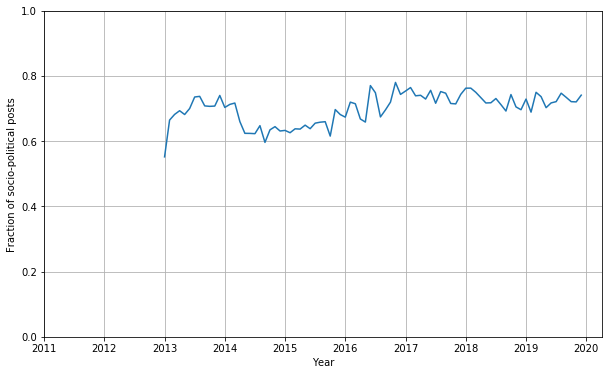

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(t2pos / (t2pos + t2neg))
plt.ylim((0, 1))
plt.grid()
plt.xticks(np.arange(0,len(t2pos) + 1, 12), 
           [f"{y}" for y in range(2011, 2021)])
plt.ylabel("Fraction of socio-political posts")
plt.xlabel("Year")
plt.savefig("../paper/fig/sociopol-cmv-ratio-over-time.pdf")

In [25]:

post2label_rdd.unpersist()

PythonRDD[2] at RDD at PythonRDD.scala:49